# Experimenting with NBA Individual Scoring Distributions (w. Bokeh Visuals)

A data project at NYU's Stern School of Business.

Written by Sagar Panchal (spp302@nyu.edu) under direction of David Backus, Spencer Lyon and Brian LeBlanc, May 2016.

# Abstract

Over Twitter a few months ago, ESPN's Tom Haberstroh described the [variability](https://twitter.com/tomhaberstroh/status/712986877184315393) of NBA players’ scoring averages (points per game). As Charlotte’s Kemba Walker and San Antonio’s Kawhi Leonard both averaged 21.0 points per game, their corresponding game logs provide two vastly different box plots, suggesting that each arrived at their averages in truly different fashions, whether because of shot selection, efficiency, or merely obeying the hot hand fallacy. Expanding this idea of plotting individual game-by-game scoring distributions could demonstrate how scoring varies at different levels in basketball (with respect to other stats as well) and provide a basic look at extracting/cleaning/shaping basketball-reference data, as well as utilizing a few tools in the Bokeh package for enhanced visual capabilities. 

**Packages Imported**

For this project, it'll be best to introduce Bokeh's functions later, so for now, we import the packages below.

In [1]:
%matplotlib inline
import pandas as pd                            #data manipulation, management
import seaborn as sns                          #complex plotting methods, used concurrently w/ Bokeh plots & charts
import numpy as np                             #mathematical foundation for pandas
import matplotlib.pyplot as plt                #basic plotting 



# Pulling, Cleaning & Shaping Game Logs

We first define a function that allows us to gather game logs, over and over again, then using a few small steps to drop missing values, clean out unnecessary columns and add important identifiers so each player's log can be used correctly. Using Seaborn, we can actually graph both points & game score distributions to give a more accurate comparison on player contributions by game. Game Score, or GmSc, is an aggregation of a player's basic-level NBA stats in one game; the formula can be found [here](http://www.basketball-reference.com/about/glossary.html).

In [2]:
def get_reg_season_basic(name, year):
    url = "http://www.basketball-reference.com/players/{0}/gamelog/{1}/".format(name, year) 
    dfs = pd.read_html(url)               # 0 is player name; 1 is year
    return dfs[8]         # out of around 20 dataframes on this page, dfs[8] returns a basic statistic game log
    
df_Kobe_grab = get_reg_season_basic("b/bryanko01", 2013)   # Kobe Bryant, 2012-13 game log (avg. 27.3 ppg)
Kobebasicpoints = df_Kobe_grab[["PTS", "Date", "G", "Opp", "GmSc"]] # points, date, game number, opponent, game score
Kobe_basic = Kobebasicpoints.drop(Kobebasicpoints.index[[20, 41, 62, 83]]) # drops non-number caption columns
Kobe_basic = Kobe_basic.dropna() # drops missing values
# kobe data is clean 
Kobe_basic["PlayerName"] = "Kobe"   # adds unique player column to use w/ other players later
Kobe_basic = Kobe_basic.set_index('G') #sets index as game so merging is possible

print(Kobe_basic.head()) # prints first five rows, head function

print("Dimensions of new dataframe are:", Kobe_basic.shape) # dimensions

  PTS        Date  Opp  GmSc PlayerName
G                                      
1  22  2012-10-30  DAL  14.7       Kobe
2  30  2012-10-31  POR  15.3       Kobe
3  40  2012-11-02  LAC  28.4       Kobe
4  15  2012-11-04  DET  16.1       Kobe
5  29  2012-11-07  UTA  19.2       Kobe
Dimensions of new dataframe are: (78, 5)


**Altering Data Types, Setting Up Stat Identifiers**

In order to graph both GmSc and PTS as y-axes to PlayerName, our x-axis, we have to actually manipulate the data so we can distinguish between GmSc and PTS as separate y inputs. In short, we need to duplicate our dataframe so that each input could be graphed as _either_ an entry for PTS in one game or GmSc of that game.

In [3]:
Kobe_pts_y1 = Kobe_basic.drop(["GmSc"], axis=1) # first, create new dataframes where only one input is present
Kobe_GmSc_y2 = Kobe_basic.drop(["PTS"], axis=1) # do the same here for Game Score by dropping Points

Kobe_pts_y1["StatType"] = "PTS" # this new column, like PlayerName, identifies the stat illustrated here as Points
Kobe_GmSc_y2["StatType"] = "GmSc" # ditto for Game Score

Kobecombine = [Kobe_pts_y1, Kobe_GmSc_y2]
Kobe_total = pd.concat(Kobecombine)     #now we have everything in one plot, but with double the entries (that's okay!)
print(Kobe_total.head()) #shows the first set, merged
print(Kobe_total.tail()) #shorts the second set, merged

print("Dimensions of new dataframe are:", Kobe_total.shape) # dimensions

         Date GmSc  Opp PTS PlayerName StatType
G                                              
1  2012-10-30  NaN  DAL  22       Kobe      PTS
2  2012-10-31  NaN  POR  30       Kobe      PTS
3  2012-11-02  NaN  LAC  40       Kobe      PTS
4  2012-11-04  NaN  DET  15       Kobe      PTS
5  2012-11-07  NaN  UTA  29       Kobe      PTS
          Date  GmSc  Opp  PTS PlayerName StatType
G                                                 
74  2013-04-05  15.5  MEM  NaN       Kobe     GmSc
75  2013-04-07  17.6  LAC  NaN       Kobe     GmSc
76  2013-04-09  26.9  NOH  NaN       Kobe     GmSc
77  2013-04-10  42.8  POR  NaN       Kobe     GmSc
78  2013-04-12  19.4  GSW  NaN       Kobe     GmSc
Dimensions of new dataframe are: (156, 6)


Next comes taking out these NaN values (filling with zeroes) by adding the present PTS/GmSc column together to create a new column to graph, **numpull**.

In [4]:
# first we should fillna wtih zero
trial = Kobe_total.fillna(0)

# crap, forgot to convert columns' dtypes to float64, doing now

Kobecopy = trial.copy()   #making a copy helps here
Kobecopy['PTS'] = Kobecopy['PTS'].astype(float) #converting one column
Kobecopy['GmSc'] = Kobecopy['GmSc'].astype(float) #converting the other ones

trial = Kobecopy
Kobe_total = trial #this assigns the work we just did back to the updated dataframe above

Kobe_total["numpull"] = Kobe_total["GmSc"] + Kobe_total["PTS"] 
# now we can add the two columns together to create something we can graph, since either GmSc or PTS will be zero

print(Kobe_total.head()) # first five rows
print(Kobe_total.tail()) # last five rows 

print("Dimensions of new dataframe are:", Kobe_total.shape)

         Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                         
1  2012-10-30     0  DAL   22       Kobe      PTS       22
2  2012-10-31     0  POR   30       Kobe      PTS       30
3  2012-11-02     0  LAC   40       Kobe      PTS       40
4  2012-11-04     0  DET   15       Kobe      PTS       15
5  2012-11-07     0  UTA   29       Kobe      PTS       29
          Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                          
74  2013-04-05  15.5  MEM    0       Kobe     GmSc     15.5
75  2013-04-07  17.6  LAC    0       Kobe     GmSc     17.6
76  2013-04-09  26.9  NOH    0       Kobe     GmSc     26.9
77  2013-04-10  42.8  POR    0       Kobe     GmSc     42.8
78  2013-04-12  19.4  GSW    0       Kobe     GmSc     19.4
Dimensions of new dataframe are: (156, 7)


**Finding a Comparison Player**

The purpose of the project was to compare player's contributions at similar scoring levels. LeBron James averaged 27.1 points per game in 2011-12, so he'll be adequate here. Given Kobe and LeBron's differing playing styles, there should be a difference in Game Score clusters once we graph. The code here is the same as above, so we'll breeze by it here.

In [5]:
df_LBJ_grab = get_reg_season_basic("j/jamesle01", 2012) #function here
LBJtestpoints = df_LBJ_grab[["PTS", "Date", "G", "Opp", "GmSc"]]
LBJ_basic = LBJtestpoints.drop(LBJtestpoints.index[[20, 41, 62]]) 

LBJ_basic["PlayerName"] = "LeBron"  #add player identifier pre-merge
LBJ_basic = LBJ_basic.set_index('G')

# y1 and y2, LBJ

LBJ_pts_y1 = LBJ_basic.drop(["GmSc"], axis=1)
LBJ_GmSc_y2 = LBJ_basic.drop(["PTS"], axis=1)

LBJ_pts_y1["StatType"] = "PTS"
LBJ_GmSc_y2["StatType"] = "GmSc"

LBJcombine = [LBJ_pts_y1, LBJ_GmSc_y2]
LBJ_total = pd.concat(LBJcombine)

# fillna, create copy for float64

LBJtrial = LBJ_total.fillna(0)
LBJcopy = LBJtrial.copy()
LBJcopy['PTS'] = LBJcopy['PTS'].astype(float)
LBJcopy['GmSc'] = LBJcopy['GmSc'].astype(float)

LBJtrial = LBJcopy     #reassign copy back to trial
LBJ_total = LBJtrial  #reassign trial back to main

# column add, LBJ

LBJ_total["numpull"] = LBJ_total["GmSc"] + LBJ_total["PTS"]

print(LBJ_total.head()) # first five rows
print(LBJ_total.tail()) # last five rows 

print("Dimensions of new dataframe are:", LBJ_total.shape) 
# note dimensions will be less since LBJ only played 62 games in the lockout year

         Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                         
1  2011-12-25     0  DAL   37     LeBron      PTS       37
2  2011-12-27     0  BOS   26     LeBron      PTS       26
3  2011-12-28     0  CHA   35     LeBron      PTS       35
4  2011-12-30     0  MIN   34     LeBron      PTS       34
5  2012-01-01     0  CHA   16     LeBron      PTS       16
          Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                          
58  2012-04-15  15.7  NYK    0     LeBron     GmSc     15.7
59  2012-04-16  32.7  NJN    0     LeBron     GmSc     32.7
60  2012-04-18  23.2  TOR    0     LeBron     GmSc     23.2
61  2012-04-19  22.8  CHI    0     LeBron     GmSc     22.8
62  2012-04-22  24.6  HOU    0     LeBron     GmSc     24.6
Dimensions of new dataframe are: (124, 7)


In [6]:
KobeLBJ = [Kobe_total, LBJ_total] # combine the dataframes
KobeLBJdata = pd.concat(KobeLBJ) # concatenate method accomplishes this
print(KobeLBJdata.head(10))
print(KobeLBJdata.tail(10))
print("Dimensions of new dataframe are:", KobeLBJdata.shape) # display, note the dimensions

          Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                          
1   2012-10-30     0  DAL   22       Kobe      PTS       22
2   2012-10-31     0  POR   30       Kobe      PTS       30
3   2012-11-02     0  LAC   40       Kobe      PTS       40
4   2012-11-04     0  DET   15       Kobe      PTS       15
5   2012-11-07     0  UTA   29       Kobe      PTS       29
6   2012-11-09     0  GSW   27       Kobe      PTS       27
7   2012-11-11     0  SAC   20       Kobe      PTS       20
8   2012-11-13     0  SAS   28       Kobe      PTS       28
9   2012-11-16     0  PHO   31       Kobe      PTS       31
10  2012-11-18     0  HOU   22       Kobe      PTS       22
          Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                          
53  2012-04-06  16.3  MEM    0     LeBron     GmSc     16.3
54  2012-04-08  16.9  DET    0     LeBron     GmSc     16.9
55  2012-04-10  31.4  BOS    0     LeBro

__The Swarm Plot__

From here, we can see that it's relatively easy to create a plot. Here's a swarmplot for the data, built with Seaborn.

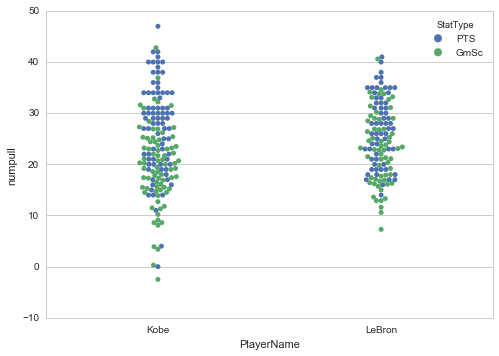

In [7]:
sns.set_style('whitegrid')
sns.swarmplot(x="PlayerName", y="numpull", hue="StatType",data=KobeLBJdata)

# Improving Our Data: Introducing Bokeh

The scatterplot in the last section is a decent representation of Kobe and LeBron's variabilities, but it confirms inferences. Kobe's a volume scorer so his data is more widespread, while LeBron is more of a consistent scorer. On another note, we can see that Kobe's points are consistently higher than his corresponding game scores, suggesting that Kobe's less efficient than LeBron. But the visual isn't aesthetically pretty and that's where Bokeh, a pure visualization package, helps us. In its high-level interface, 'bokeh.charts', we'll be able to create beautiful plots expediently while having tools to closely inspect our data as well.

We'll first start with importing packages.

In [8]:
from bokeh.charts import Histogram, show, hplot, output_file 
from bokeh.io import output_notebook
# this imports a histogram plot package from Bokeh's interface, along with content to save and show the file

Several of Bokeh's basics are here. We can create a Bokeh histogram immediately, save the file as an HTML for our uses and show the file below on this iPython Notebook. Check it out:

In [9]:
histKobeLBJ = Histogram(KobeLBJdata, values='GmSc', label='PlayerName', color='PlayerName', legend='top_right',
                  title="Sample Game Score Histogram", plot_width=400)

#output_file("histKobe.html", title='histogram Kobe example') # this would docu. output file, would open in new tab

output_notebook()   # this technicality allows us to put the Bokeh data display directly below us
show(histKobeLBJ)   # this puts the output both below us and opens a new tab with the same thing

Loading BokehJS ...

Ignoring the erreneous front data (a high amount of the GmSc column, as you may recall, are filled with zeroes), we can see that Kobe's game scores are significantly worse on average than LeBron's, even as they averaged the same amount of points. 

Notice the tabs up top: each allows us to toy around with the graph in different ways. We can resize the graph, zoom in on certain sections with either a box or lasso, and if you'd like, you can even save this to your own computer without having to run the code, as a spectator. These are the fundamental features of the Bokeh display. For different types of graphs in bokeh.charts, we'd need to import different things, but the premise is similar.

**Adding a Hovertool to our Visuals**

In Bokeh, it's easy to create charts that can help us compare stats between players with 'bokeh.charts'. We can also create an inspector that illustrates each point's opponent, date and stats with something called a **hovertool**. Let's work on it below. 

First, we'll create a scatter with no hovertool to start: it requires cleaning so it's a separate step.

In [10]:
from bokeh.charts import Scatter, output_file, show   # creating scatterplot visual over bokeh.charts
from bokeh.io import output_notebook #output_notebook to show our work below

KobeLBJ2 = [Kobe_basic, LBJ_basic] #merging pre-modified box scores from first Kobe cell, corres. LBJ cell
KobeLBJscatter = pd.concat(KobeLBJ2) #concatenate, like above

KobeLBJscatter['PTS'] = KobeLBJscatter['PTS'].astype(float) # converting to float64 to clean coordinates
KobeLBJscatter['GmSc'] = KobeLBJscatter['GmSc'].astype(float)

scatter = Scatter(KobeLBJscatter, x='PTS', y='GmSc', color='PlayerName', #this is from Bokeh, not mpl or sns
                  title='Scatter Sample', xlabel='PTS', ylabel='Game Score', legend='top_right')

output_notebook() #output

show(scatter) #show

Loading BokehJS ...

This graph is rather static, so now we'll add **hovertool** to it to make the visual more interactive. We'll import hover from 'bokeh.models', a deep-level development portion of the Bokeh interface and then work from there.

**To use the Hovertool, just scroll onto the plot below.**

In [11]:
from bokeh.models import HoverTool 
from bokeh.plotting import ColumnDataSource 
# imports the ability for us to put columns (opp., etc) as data sources on hover

source = ColumnDataSource(KobeLBJscatter)

TOOLS = "resize, save, pan, hover, box_zoom, wheel_zoom" # adds hovertool to standard list of tools above plot

scatter = Scatter(KobeLBJscatter, x='PTS', y='GmSc', color='PlayerName', #this is from Bokeh, not mpl or sns
                  title='Kobe vs. LBJ identifier', xlabel='PTS', ylabel='Game Score', 
                  legend='top_right', plot_width=500, plot_height=500, tools=TOOLS) 
                 # note how tools=TOOLS sets the list of tools above to our scatter

hover = scatter.select(dict(type=HoverTool)) # what kind of tool is hovertool?
hover.tooltips = [('PTS', '$x'),('GmSc', '$y')]  
# tooltips tells us what info comes up when our mouse hovers over it

output_notebook() # output

show(scatter) # show

Loading BokehJS ...

As you can see above, the HoverTool is helpful with giving us an approximate PTS/GmSc for every coordinate when we scroll across the data. Plus, Bokeh's resizing tools really come in hand here: you can make the graph itself bigger or smaller and, if you feel like making it more concise, you can zoom in on the x-axis to create a techincal limit at 0 PTS. But additional info would be desired: maybe the opponent each player was playing at the time, perhaps. 

I found a reference function that puts scatter plots with appropriate hovertools by [Robin Wilson](http://blog.rtwilson.com/), a wonderful blogger/affacionado/coder/PhD student from the UK, and will be using it here. If you would like to see the explanation for the function and the purpose of its existence, you can find it [here](http://blog.rtwilson.com/bokeh-plots-with-dataframe-based-tooltips/).

In [12]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import hplot # hplot allows us to showcase the two plots horizontally, next to one another


def scatter_with_hover(df, x, y,                # reference fct begins here, explanation at link
                       fig=None, cols=None, name=None, 
                       marker='square', fig_width=500, fig_height=500, **kwargs): # changed marker from 'x'
    if fig is None:
        fig = figure(width=fig_width, height=fig_height, tools=['box_zoom', 'reset'])
    source = ColumnDataSource(data=df) # establishes ColumnDataSource as df
    if name is None:
        name = 'main'
    fig.scatter(df[x], df[y], source=source, name=name, marker=marker, **kwargs)
    hover = HoverTool(names=[name])
    if cols is None:
        hover.tooltips = [(c, '@' + c) for c in df.columns] # these important rules set up our columns for return
    else:
        hover.tooltips = [(c, '@' + c) for c in cols] # same here
    hover.tooltips.append(('index', '$index')) # this plugs the index into our hover
    fig.add_tools(hover) # this adds hovertool to our list of tools
    return fig

fig = scatter_with_hover(KobeLBJscatter, 'PTS', 'GmSc',  # using KobeLBJscatter, as told earlier
                         cols=['PlayerName','Date','Opp','PTS','GmSc']) # execution of the fct w/ all columns

# SIDE NOTE: in Bokeh, you can alter graphs by simply tab completing methods onto existing figures b/c your content
# is already set up as a figure objects, as the importing process shows above 

fig.xaxis.axis_label = "PTS" # set x-axis label
fig.yaxis.axis_label = 'Game Score' # set y-axis label
fig.title = 'Kobe vs. LeBron Hover' # set graph title
fig.title_text_font_size = '14pt' # text font size

p = hplot(fig, scatter) # hplot will show both plots next to one another

output_notebook() # output to notebook 
show(p) # show

Loading BokehJS ...

So, thanks to Robin's function, we notice two changes. We lose our colors from the first plot but, since Bokeh allows the user to horizontally (or vertically) position plots next to one another, we can utilize Robin's function and display our previous, manually-created plot right next to it. It is, admittedly, a bit redundant, but still gets our data the way we want it.

# More Examples: Thinking Beyond Our Code

**Where Do We Go From Here?**

Comparing a player's Points to their Game Score, unless there's an actual rationale behind it, is a decently futile exercise for NBA players that are good at maintaining their averages night to night, without many changes: it's known that the more supplementary stats the player has besides points (rebounds, assists, etc.), the better their Game Score will be. 

However, the lower an NBA player's point averages are, the less likely they are to be the cornerstone of the scoring/passing for their team offensively, meaning that there could be more variability in their contributions, night to night. I think this would stand true for players who score maybe 10-12 points less each night than Kobe/LeBron. It'd especially be interesting if we could see whether efficiency-targeted playing styles in present-day ball (i.e., analytics) drastically affect Game Score given the amount of shots taken in a certain game: Game Score accounts for FGA (field-goal attempts) but doesn't account for 3PA (three-point attempts) in its calculations. 

Given the Golden State Warriors' record-breaking season, it would be easiest to compare Draymond Green to the player he's most compared to in league circles, the Bulls' Scottie Pippen. Here's the raw stats I'd be working with:

*Scottie Pippen, age 27, 1992-93:*
18.6 PPG, 6.3 APG, 7.7 RPG, 2.1 SPG, 0.9 BPG, .473 FG%, .237 3P%, .663 FT%, 81 games played.

*Draymond Green, age 25, 2015-16:*
14.0 PPG, 7.4 APG, 9.5 RPG, 1.5 SPG, 1.4 BPG, .490 FG%, .388 3P%, .696 FT%, 81 games played.

Given just how close these two players are statistically, I'd like to grab their game logs and run the same type of graphs. This time, things will be abbreviated since all the coding was shown earlier.

In [13]:
df_Dray_grab = get_reg_season_basic("g/greendr01", 2016) #function here
Draytestpoints = df_Dray_grab[["PTS", "Date", "G", "Opp", "GmSc"]]
Dray_basic = Draytestpoints.drop(Draytestpoints.index[[20, 39, 41, 62, 83]]) 

Dray_basic["PlayerName"] = "Draymond"  #add player identifier pre-merge
Dray_basic = Dray_basic.set_index('G')

# y1 and y2, Draymond

Dray_pts_y1 = Dray_basic.drop(["GmSc"], axis=1)
Dray_GmSc_y2 = Dray_basic.drop(["PTS"], axis=1)

Dray_pts_y1["StatType"] = "PTS"
Dray_GmSc_y2["StatType"] = "GmSc"

Draycombine = [Dray_pts_y1, Dray_GmSc_y2]
Dray_total = pd.concat(Draycombine)

# fillna, create copy for float64

Draytrial = Dray_total.fillna(0)
Draycopy = Draytrial.copy()
Draycopy['PTS'] = Draycopy['PTS'].astype(float)
Draycopy['GmSc'] = Draycopy['GmSc'].astype(float)

Draytrial = Draycopy     #reassign copy back to trial
Dray_total = Draytrial  #reassign trial back to main

# column add, Draymond

Dray_total["numpull"] = Dray_total["GmSc"] + Dray_total["PTS"] # checked, this runs

In [14]:
df_Pip_grab = get_reg_season_basic("p/pippesc01", 1993) #function here
Piptestpoints = df_Pip_grab[["PTS", "Date", "G", "Opp", "GmSc"]]
Pip_basic = Piptestpoints.drop(Piptestpoints.index[[20, 41, 62, 83]]) 

Pip_basic["PlayerName"] = "Scottie"  #add player identifier pre-merge
Pip_basic = Pip_basic.set_index('G')

# y1 and y2, Scottie

Pip_pts_y1 = Pip_basic.drop(["GmSc"], axis=1)
Pip_GmSc_y2 = Pip_basic.drop(["PTS"], axis=1)

Pip_pts_y1["StatType"] = "PTS"
Pip_GmSc_y2["StatType"] = "GmSc"

Pipcombine = [Pip_pts_y1, Pip_GmSc_y2]
Pip_total = pd.concat(Pipcombine)

# fillna, create copy for float64

Piptrial = Pip_total.fillna(0)
Pipcopy = Piptrial.copy()
Pipcopy['PTS'] = Pipcopy['PTS'].astype(float)
Pipcopy['GmSc'] = Pipcopy['GmSc'].astype(float)

Piptrial = Pipcopy     #reassign copy back to trial
Pip_total = Piptrial  #reassign trial back to main

# column add, Scottie

Pip_total["numpull"] = Pip_total["GmSc"] + Pip_total["PTS"] # checked, it runs

In [15]:
DrayPip = [Dray_total, Pip_total] # combine the dataframes
DrayPipdata = pd.concat(DrayPip)
print(DrayPipdata.head(10))
print(DrayPipdata.tail(10))
print("Dimensions of new dataframe are:", DrayPipdata.shape)# concatenate method accomplishes this, checked, this runs as well

          Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                          
1   2015-10-27     0  NOP   10   Draymond      PTS       10
2   2015-10-30     0  HOU    9   Draymond      PTS        9
3   2015-10-31     0  NOP   21   Draymond      PTS       21
4   2015-11-02     0  MEM   11   Draymond      PTS       11
5   2015-11-04     0  LAC   10   Draymond      PTS       10
6   2015-11-06     0  DEN   12   Draymond      PTS       12
7   2015-11-07     0  SAC   10   Draymond      PTS       10
8   2015-11-09     0  DET    6   Draymond      PTS        6
9   2015-11-11     0  MEM    7   Draymond      PTS        7
10  2015-11-12     0  MIN   23   Draymond      PTS       23
          Date  GmSc  Opp  PTS PlayerName StatType  numpull
G                                                          
72  1993-04-09  12.3  ATL    0    Scottie     GmSc     12.3
73  1993-04-10   5.4  IND    0    Scottie     GmSc      5.4
74  1993-04-12   5.6  DET    0    Scotti

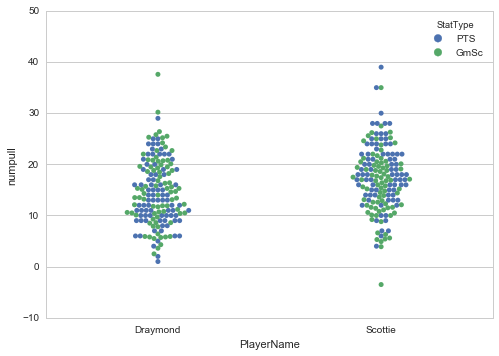

In [16]:
sns.set_style('whitegrid')
sns.swarmplot(x="PlayerName", y="numpull", hue="StatType",data=DrayPipdata)

In [17]:
from bokeh.models import HoverTool 
from bokeh.plotting import ColumnDataSource 
# imports the ability for us to put columns (opp., etc) as data sources on hover

DrayPip2 = [Dray_basic, Pip_basic] #merging pre-modified box scores
DrayPipscatter = pd.concat(DrayPip2) #concatenate, like above

DrayPipscatter['PTS'] = DrayPipscatter['PTS'].astype(float) # converting to float64 to clean coordinates
DrayPipscatter['GmSc'] = DrayPipscatter['GmSc'].astype(float)

source = ColumnDataSource(KobeLBJscatter)

TOOLS = "resize, save, pan, hover, box_zoom, wheel_zoom" # adds hovertool to standard list of tools above plot

scatter = Scatter(DrayPipscatter, x='PTS', y='GmSc', color='PlayerName', #this is from Bokeh, not mpl or sns
                  title='Draymond vs. Pippen identifier', xlabel='PTS', ylabel='Game Score', 
                  legend='bottom_right', plot_width=500, plot_height=500, tools=TOOLS) 
                 # note how tools=TOOLS sets the list of tools above to our scatter

hover = scatter.select(dict(type=HoverTool)) # what kind of tool is hovertool?
hover.tooltips = [('PTS', '$x'),('GmSc', '$y')]  
# tooltips tells us what info comes up when our mouse hovers over it

In [18]:
fig = scatter_with_hover(DrayPipscatter, 'PTS', 'GmSc',  # using DrayPipscatter
                         cols=['PlayerName','Date','Opp','PTS','GmSc']) # execution of the fct w/ all columns
fig.xaxis.axis_label = "PTS" # set x-axis label
fig.yaxis.axis_label = 'Game Score' # set y-axis label
fig.title = 'Draymond vs. Pippen Hover' # set graph title
fig.title_text_font_size = '14pt' # text font size

p = hplot(fig, scatter) # hplot will show both plots next to one another

output_notebook() # output to notebook 
show(p) # show

Loading BokehJS ...

A basic glimpse of our graphs show observations about efficiency and to an extent, usage. Draymond definitely scores less points to arrive at the same Game Scores as Scottie, but at the same time, Scottie's Game Scores are still noticeably more present than Draymond's if we move past say, game scores of 9 or above, including a huge cluster of Scottie's scores around what would be coordinate (16, 10) on the graph. 

## Concluding Message, Data & Sources

After using both Seaborn and Bokeh to examine individual NBA player game logs to determine how scoring distributions, we can infer several conclusions about the data from our distributions and general knowledge of each player's playing style (i.e., how they received their scoring opportunities). For instance, it would be wise to infer that if a player receives more of their scoring opportunities through isolation scoring (Kobe comes to mind), their corresponding Game Score becomes both more varied (less consistent) *and* more reliant on the pure number of points they score. In a vacuum, this makes sense: Scottie Pippen's distribution has quite a few more outliers than Draymond's or even LeBron's, simply because he most likely received more isolation play calls in a pre-analytic heavy basketball scheme in the early-90's, as compared to now. 

The conundrum to actually amaking quantitative conclusions on this data falls, ironically, with data itself: stats that track how shot types, player tracking and spatial efficiency (i.e., SportsVU) only were released to the public two years ago, so most of these comparisons can't utilize evidence from these standards. However, a library of old footage exists on YouTube and other platforms and moreover, I believe that using basic stats to examine distributions over years could definitely help better understand long-view consequences of players' stats in the analytics movement. This may seem basic, but at its core, it opens up a beneficial question that could direct a new perspective of examining stats in the future. 

**A Short Note On Sources**

For this project, most of the intuition came from my own head. I'm very into basketball, once wrote about it and still keep up with it as a daily passion to this day. All data, though, is from [Basketball Reference](http://www.basketball-reference.com/) and their data libraries.